In [3]:
!pip install python-chess
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 MB 1.4 MB/s eta 0:00:0000:0100:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 6.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 6.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/1

In [4]:
import chess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [5]:
def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_piece(piece))
        board_list.append(row_list)
    return np.array(board_list)

In [6]:
df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/train.csv', index_col='id')

# We'll only use the first 10000 examples so things run fast,
# but you'll get better performance if you remove this line
train_df = df[:20000]

# We'll also grab the last 1000 examples as a validation set
val_df = df[-1000:]
train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/train-an-ai-to-play-chess/train.csv'

In [5]:
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

In [6]:
X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']

X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

In [7]:
model = Sequential([
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1),
])

model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error')

In [8]:
history = model.fit(
    X_train,
    y_train,
    epochs=40,
    validation_data=(X_val, y_val))

Epoch 1/40
625/625 [==============================] - 12s 18ms/step - loss: 136050.1562 - val_loss: 129615.2266
Epoch 2/40
625/625 [==============================] - 11s 17ms/step - loss: 111424.0547 - val_loss: 119390.0234
Epoch 3/40
625/625 [==============================] - 11s 18ms/step - loss: 95928.9766 - val_loss: 93050.7109
Epoch 4/40
625/625 [==============================] - 11s 17ms/step - loss: 82403.2266 - val_loss: 87255.3516
Epoch 5/40
625/625 [==============================] - 11s 17ms/step - loss: 71928.1484 - val_loss: 80838.5938
Epoch 6/40
625/625 [==============================] - 11s 18ms/step - loss: 63205.7617 - val_loss: 68567.9844
Epoch 7/40
625/625 [==============================] - 11s 18ms/step - loss: 56734.0625 - val_loss: 70995.8672
Epoch 8/40
625/625 [==============================] - 11s 17ms/step - loss: 50943.4844 - val_loss: 62237.1445
Epoch 9/40
625/625 [==============================] - 11s 18ms/step - loss: 46870.2344 - val_loss: 78952.2422
Epoch 

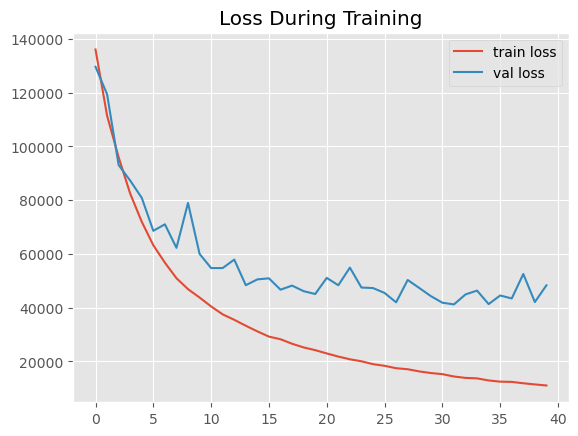

In [9]:
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

In [10]:
def play_nn(fen, show_move_evaluations=False):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then evaluate all legal moves
    moves = []
    input_vectors = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        moves.append(move)
        input_vectors.append(encode_board(str(candidate_board)).astype(np.int32).flatten())
    
    input_vectors = np.stack(input_vectors)
    # This is where our model gets to shine! It tells us how good the resultant score board is for black:
    scores = model.predict(input_vectors, verbose=0)
    # argmax gives us the index of the highest scoring move
    if board.turn == chess.BLACK:
        index_of_best_move = np.argmax(scores)
    else:
        # If we're playing as white, we want black's score to be as small as possible, so we take argmax of the negative of our array
        index_of_best_move = np.argmax(-scores)

    if show_move_evaluations:
        print(zip(moves, scores))
        
    best_move = moves[index_of_best_move]

    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [11]:
test_df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/test.csv')

test_df.head()

,id,board
0,7937,r1bqk2r/pp2bpp1/2n1pn1p/2pp4/3P1B2/2P1PN2/PP1N...
1,20035,2r2k1r/pp2pp1p/1q3npb/1B1N4/8/P4Q1P/1P3PP1/R2R...
2,71263,3b4/8/5k2/5p2/8/4K3/8/5B2 b - - 2 80
3,61997,5k2/R7/3r3p/2PP2pP/5pb1/P1K5/6B1/8 w - - 1 61
4,26510,r3r1k1/pb3p1p/1p1q2p1/3P1p2/3Q1P2/5N2/PP4PP/3R...


In [12]:
test_df['best_move'] = test_df['board'].apply(play_nn)

In [13]:
test_df['best_move']

0      e7d6
1      d1f1
2      f6f7
3      c5d6
4      a8c8
       ... 
195    a5a6
196    f7g6
197    a8a7
198    h5e5
199    b8c8
Name: best_move, Length: 200, dtype: object